# Lesson 1 - Keras implementation of fast ai part 1 v2
- This is a Keras implementation of Jeremy Howard's fastai part 1 v2 lesson 1 (original version is in PyTorch)
- This has only been tested with the TensorFlow backend to Keras

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.utils import *
from fastai.learner import *
from fastai.dataset import *

Using TensorFlow backend.


We will use the dogs and cats dataset

path should be replaced with the path to your downloaded dogs and cats dataset

For the original Keras dogs/cats lesson1 and instructions on downloading visit:
https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson1.ipynb

In [2]:
path="/home/jeff/projects/fastai/data/dogscats/" #update with your path to cats and dogs
sz = 224

Loading in Keras' off the shelf/pretrained ResNet50 model.

***note: the PyTorch course uses ResNet34. After many hours spent writing code to convert PyTorch models and weights into Keras. I opted to use Keras' ResNet50.***

In [3]:
arch = ResNet50
data = ImageClassifierData.from_paths(path=path, tfms = tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [4]:
learn.lr_find()

Epoch 1/1
176/360 [=============>................] - ETA: 34s - loss: 0.4567

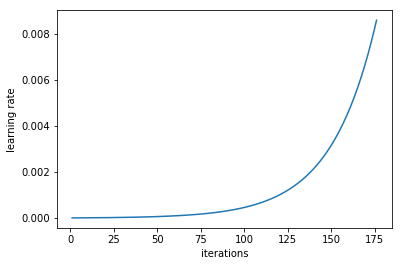

In [5]:
learn.sched.plot_lr()

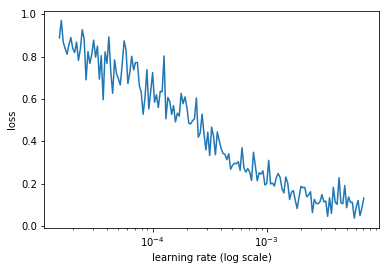

In [6]:
learn.sched.plot()

As you can see in the plot above it appears the optimal learning rate to set is .01, but i like to move fast so i'm going to use .08

**Data Augmentation on the training data**

Now time to start training!  I noticed that the pretrained Keras ResNet50 model is not quite as accurate in my opinion as the pretrained PyTorch ResNet50 model.

In [7]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.RANDOM, 
                  rotation_range=10, zoom_range=0.1, horizontal_flip=True)

In [8]:
#need to add random lighten
data = ImageClassifierData.from_paths(path=path, tfms = tfms)
learn = ConvLearner.pretrained(arch, data)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [9]:
learn.fit(.08, 4)

Epoch 1/4
360/360 [==============================] - 73s - loss: 0.3342 - acc: 0.9618 - val_loss: 0.4088 - val_acc: 0.9625
Epoch 2/4
360/360 [==============================] - 73s - loss: 0.2553 - acc: 0.9740 - val_loss: 0.2367 - val_acc: 0.9750
Epoch 3/4
360/360 [==============================] - 72s - loss: 0.2510 - acc: 0.9757 - val_loss: 0.3928 - val_acc: 0.9655
Epoch 4/4
360/360 [==============================] - 72s - loss: 0.2571 - acc: 0.9759 - val_loss: 0.2149 - val_acc: 0.9770


Evaluate function may run a little slow.  I find that Keras generator's are not the fastest compared to the ones in the fastai PyTorch library.  Generally I try to load the entire dataset into memory, but since this repository is meant to be shared I opted for generators so that it works for a wider audience.

Fit for 3 epochs with a Cyclical Learning Rate

In [10]:
learn.fit(.08, 2, cycle_len=1, cycle_mult=2)

Epoch 1/3
360/360 [==============================] - 73s - loss: 0.2234 - acc: 0.9793 - val_loss: 0.2014 - val_acc: 0.9790
Epoch 2/3
360/360 [==============================] - 73s - loss: 0.2362 - acc: 0.9779 - val_loss: 0.3014 - val_acc: 0.9735
Epoch 3/3
360/360 [==============================] - 74s - loss: 0.1920 - acc: 0.9816 - val_loss: 0.2519 - val_acc: 0.9760


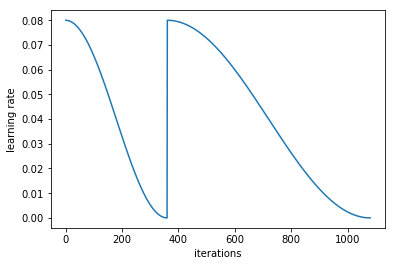

In [11]:
learn.sched.plot_lr()

In [12]:
learn.save('keras_resnet50.hdf5')

Make all layers trainable

In [13]:
learn.unfreeze()

In [14]:
learn.fit([0.0001, .001, .01], 3, cycle_len=1, cycle_mult=2)

Epoch 1/7
360/360 [==============================] - 223s - loss: 0.1533 - acc: 0.9847 - val_loss: 0.1801 - val_acc: 0.9855
Epoch 2/7
360/360 [==============================] - 219s - loss: 0.1379 - acc: 0.9854 - val_loss: 0.2030 - val_acc: 0.9800
Epoch 3/7
360/360 [==============================] - 220s - loss: 0.0975 - acc: 0.9893 - val_loss: 0.1973 - val_acc: 0.9795
Epoch 4/7
360/360 [==============================] - 219s - loss: 0.0953 - acc: 0.9892 - val_loss: 0.2123 - val_acc: 0.9790
Epoch 5/7
360/360 [==============================] - 220s - loss: 0.0722 - acc: 0.9912 - val_loss: 0.1732 - val_acc: 0.9790
Epoch 6/7
360/360 [==============================] - 219s - loss: 0.0722 - acc: 0.9916 - val_loss: 0.1342 - val_acc: 0.9845
Epoch 7/7
360/360 [==============================] - 220s - loss: 0.0614 - acc: 0.9921 - val_loss: 0.1560 - val_acc: 0.9850


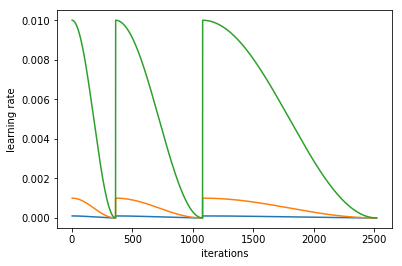

In [15]:
learn.sched.plot_lr()

In [16]:
%%time
learn.model.evaluate_generator(data[1], steps=math.ceil(data[1].samples/data[1].batch_size), workers=4 )

CPU times: user 19 s, sys: 284 ms, total: 19.3 s
Wall time: 6.77 s


[0.17039716272840053, 0.98450000000000004]

In [17]:
learn.save('keras_resnet50_2.hdf5')